In [ ]:
import pandas as pd
import re
import numpy as np
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/TA/FIX/FIX2/Dataset Lagu Pop Indonesia Revisi.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Judul Lagu,Penyanyi,Genre,Lirik Lagu,Tahun Rilis,Label Emosi
0,bagaimana kalau aku tidak baik baik saja,judika,pop,Andai aku bisa memutar waktu\nAku tak ingin me...,2021,sedih
1,hanya rindu,andmesh,pop,"Saat ku sendiri, ku lihat foto dan video\nBers...",2019,sedih
2,jangan,"marion jola, rayi putra",pop,Hanya dengan sepatah kata\r\nKau buatku larut ...,2018,marah
3,tak segampang itu,anggi marito,pop,Waktu demi waktu\nHari demi hari\nSadar ku t'l...,2022,sedih
4,tak ada ujungnya,rony parulian,pop,Ku temukan satu sisi dalam diri\nWarna warni p...,2024,senang


In [ ]:
# Kamus normalisasi
alay_dict = {
    "gk": "tidak", "ga": "tidak", "ngga": "tidak", "nggak": "tidak", "tdk": "tidak",
    "tak": "tidak", "bgt": "banget", "bgtu": "banget", "sm": "sama", "syg": "sayang",
    "jg": "juga", "udh": "sudah", "tp": "tapi", "dr": "dari", "dgn": "dengan",
    "aja": "saja", "km": "kamu", "aq": "saya", "aku": "saya", "trs": "terus",
    "trus": "terus", "t'rus": "terus", "tlah": "telah", "t'lah": "telah", "kan": "akan",
    "tuk": "untuk", "slalu": "selalu", "s'lalu": "selalu", "ku": "aku", "skrg": "sekarang",
    "bsk": "besok", "blm": "belum", "lg": "lagi"
}

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    words = text.split()
    words = [alay_dict.get(w, w) for w in words]
    return ' '.join(words)

# Preprocessing
df['Label Emosi'] = df['Label Emosi'].str.lower()
label_map = {'senang':0, 'sedih':1, 'tenang':2, 'marah':3}
df['label'] = df['Label Emosi'].map(label_map)
df['cleaned_lirik'] = df['Lirik Lagu'].apply(clean_text)
df = df[['cleaned_lirik','label']]

df['label'] = df['label'].astype('int64')
print(df['label'].value_counts())

# Simpan hasil preprocessing
df.to_csv('/content/drive/MyDrive/TA/FIX/FIX2/k-fold/k-fold2/hasil do2/cleaned_dataset.csv', index=False)

label
1    726
0    352
2    284
3    138
Name: count, dtype: int64


<ipython-input-3-4044807239>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].astype('int64')


In [ ]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

# K-Fold splitting + full oversampling
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df['cleaned_lirik'], df['label'])):
    train_data = df.iloc[train_idx]
    val_data = df.iloc[val_idx]

    # Oversampling hanya di train
    X_train = train_data['cleaned_lirik'].to_frame()
    y_train = train_data['label']

    majority_class = 1  # kelas sedih
    n_majority = y_train.value_counts()[majority_class]

    # Full oversampling: semua kelas disamakan jumlahnya dengan mayoritas
    sampling_strategy = {label: n_majority for label in y_train.unique()}

    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

    train_resampled = pd.DataFrame({
        'cleaned_lirik': X_resampled['cleaned_lirik'],
        'label': y_resampled
    })

    train_resampled.to_csv(f'/content/drive/MyDrive/TA/FIX/FIX2/k-fold/k-fold2/hasil do2/train_fold_{fold}.csv', index=False)
    val_data.to_csv(f'/content/drive/MyDrive/TA/FIX/FIX2/k-fold/k-fold2/hasil do2/val_fold_{fold}.csv', index=False)

    print(f"Fold {fold+1}: Train={len(train_resampled)}, Val={len(val_data)}")

Fold 1: Train=2320, Val=300
Fold 2: Train=2324, Val=300
Fold 3: Train=2324, Val=300
Fold 4: Train=2324, Val=300
Fold 5: Train=2324, Val=300


In [ ]:
!pip install transformers datasets scikit-learn numpy==1.26.4

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model_name = 'cahya/distilbert-base-indonesian'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Mapping label buat hasil csv
label_map_rev = {0: 'senang', 1: 'sedih', 2: 'tenang', 3: 'marah'}

k = 5
all_train_loss = []
all_val_loss = []
all_val_acc = []
all_conf_matrix = []

for fold in range(k):
    print(f"\n=== Fine-tuning Fold {fold+1} ===")

    train_df = pd.read_csv(f'/content/drive/MyDrive/TA/FIX/FIX2/k-fold/k-fold2/hasil do2/train_fold_{fold}.csv')
    val_df = pd.read_csv(f'/content/drive/MyDrive/TA/FIX/FIX2/k-fold/k-fold2/hasil do2/val_fold_{fold}.csv')

    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)

    # Tokenizer with step-by-step saving
    def tokenize_with_steps(batch):
        texts = batch['cleaned_lirik']
        tokens_list = []
        encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=512)

        for text in texts:
            tokens = tokenizer.tokenize(text)
            tokens_list.append(tokens)

        batch_out = {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
            'tokens': tokens_list,
            'label': batch['label']
        }
        return batch_out

    train_dataset = train_dataset.map(tokenize_with_steps, batched=True)
    val_dataset = val_dataset.map(tokenize_with_steps, batched=True)

    # Simpan hasil tokenisasi ke CSV
    train_tokenized_df = pd.DataFrame({
        'cleaned_lirik': train_df['cleaned_lirik'],
        'tokens': train_dataset['tokens'],
        'input_ids': train_dataset['input_ids'],
        'attention_mask': train_dataset['attention_mask'],
        'label': train_dataset['label']
    })

    val_tokenized_df = pd.DataFrame({
        'cleaned_lirik': val_df['cleaned_lirik'],
        'tokens': val_dataset['tokens'],
        'input_ids': val_dataset['input_ids'],
        'attention_mask': val_dataset['attention_mask'],
        'label': val_dataset['label']
    })

    train_tokenized_df.to_csv(f'/content/drive/MyDrive/TA/FIX/FIX2/k-fold/k-fold2/hasil do2/train_tokenized_steps_fold_{fold}.csv', index=False)
    val_tokenized_df.to_csv(f'/content/drive/MyDrive/TA/FIX/FIX2/k-fold/k-fold2/hasil do2/val_tokenized_steps_fold_{fold}.csv', index=False)

    # Set format for training
    train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions[0].argmax(-1)
        acc = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average='macro')
        return {'accuracy': acc, 'f1': f1}

    train_loss_per_epoch = []
    val_loss_per_epoch = []
    val_acc_per_epoch = []

    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold}",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        eval_strategy="epoch",
        save_strategy="no",
        logging_strategy="epoch",
        learning_rate=2e-5,
        weight_decay=0.01,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # Simpan log loss/acc dari trainer
    logs = trainer.state.log_history
    for log in logs:
        if 'loss' in log:
            train_loss_per_epoch.append(log['loss'])
        if 'eval_loss' in log:
            val_loss_per_epoch.append(log['eval_loss'])
        if 'eval_accuracy' in log:
            val_acc_per_epoch.append(log['eval_accuracy'])

    all_train_loss.append(train_loss_per_epoch)
    all_val_loss.append(val_loss_per_epoch)
    all_val_acc.append(val_acc_per_epoch)

    # Evaluation & Confusion Matrix
    preds = trainer.predict(val_dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions[0], axis=1)

    print(classification_report(y_true, y_pred, target_names=['senang','sedih','tenang','marah']))
    cm = confusion_matrix(y_true, y_pred)
    all_conf_matrix.append(cm)

    # Simpan hasil prediksi vs aktual
    results_df = pd.DataFrame({
        'cleaned_lirik': val_df['cleaned_lirik'],
        'actual_label': y_true,
        'predicted_label': y_pred,
        'actual_text': [label_map_rev[label] for label in y_true],
        'predicted_text': [label_map_rev[label] for label in y_pred]
    })

    # Simpan ke CSV per fold
    results_df.to_csv(f'/content/drive/MyDrive/TA/FIX/FIX2/k-fold/k-fold2/hasil do2/prediksi_vs_aktual_fold_{fold}.csv', index=False)

# === Summary Akhir ===
print("\n=== Summary Done ===")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/230k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


=== Fine-tuning Fold 1 ===


Map:   0%|          | 0/2320 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.066100,1.057297,0.536667,0.519269
2,0.502300,0.972823,0.633333,0.580942
3,0.214900,1.095409,0.656667,0.599551
4,0.086200,1.327088,0.643333,0.574522
5,0.043200,1.358677,0.640000,0.574945


              precision    recall  f1-score   support

      senang       0.66      0.49      0.56        71
       sedih       0.68      0.83      0.75       146
      tenang       0.48      0.38      0.42        56
       marah       0.58      0.56      0.57        27

    accuracy                           0.64       300
   macro avg       0.60      0.56      0.57       300
weighted avg       0.63      0.64      0.63       300


=== Fine-tuning Fold 2 ===


Map:   0%|          | 0/2324 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.042900,1.051940,0.553333,0.506520
2,0.493900,1.164592,0.580000,0.512226
3,0.220400,1.278074,0.613333,0.543439
4,0.091500,1.560359,0.603333,0.539225
5,0.049500,1.608754,0.626667,0.542472


              precision    recall  f1-score   support

      senang       0.69      0.53      0.60        70
       sedih       0.66      0.82      0.73       145
      tenang       0.47      0.40      0.43        57
       marah       0.56      0.32      0.41        28

    accuracy                           0.63       300
   macro avg       0.59      0.52      0.54       300
weighted avg       0.62      0.63      0.61       300


=== Fine-tuning Fold 3 ===


Map:   0%|          | 0/2324 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.031700,1.191631,0.463333,0.457196
2,0.475300,1.112679,0.583333,0.478203
3,0.197800,1.369023,0.610000,0.533271
4,0.090000,1.571556,0.596667,0.512942
5,0.043800,1.665743,0.600000,0.515762


              precision    recall  f1-score   support

      senang       0.60      0.54      0.57        70
       sedih       0.69      0.74      0.72       145
      tenang       0.43      0.46      0.44        57
       marah       0.40      0.29      0.33        28

    accuracy                           0.60       300
   macro avg       0.53      0.51      0.52       300
weighted avg       0.59      0.60      0.60       300


=== Fine-tuning Fold 4 ===


Map:   0%|          | 0/2324 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.067300,0.957527,0.603333,0.542625
2,0.522800,0.965547,0.630000,0.541784
3,0.228600,1.189826,0.616667,0.524851
4,0.106100,1.353610,0.623333,0.524556
5,0.052600,1.405005,0.640000,0.551603


              precision    recall  f1-score   support

      senang       0.67      0.64      0.66        70
       sedih       0.69      0.81      0.75       145
      tenang       0.51      0.33      0.40        57
       marah       0.41      0.39      0.40        28

    accuracy                           0.64       300
   macro avg       0.57      0.54      0.55       300
weighted avg       0.63      0.64      0.63       300


=== Fine-tuning Fold 5 ===


Map:   0%|          | 0/2324 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.090500,0.986585,0.583333,0.541548
2,0.512700,0.917473,0.656667,0.572073
3,0.203800,1.130156,0.653333,0.582046
4,0.093300,1.314909,0.673333,0.602741
5,0.048500,1.399187,0.673333,0.602031


              precision    recall  f1-score   support

      senang       0.66      0.59      0.62        71
       sedih       0.74      0.84      0.79       145
      tenang       0.50      0.46      0.48        57
       marah       0.63      0.44      0.52        27

    accuracy                           0.67       300
   macro avg       0.63      0.58      0.60       300
weighted avg       0.66      0.67      0.67       300


=== Summary Done ===


In [ ]:
import pandas as pd

# Baca semua hasil prediksi
k = 5
dfs = []

for fold in range(k):
    df = pd.read_csv(f'/content/drive/MyDrive/TA/FIX/FIX2/k-fold/k-fold2/hasil do2/prediksi_vs_aktual_fold_{fold}.csv')
    df['fold'] = fold+1
    dfs.append(df)

# Gabungkan semua jadi 1 dataframe
all_results = pd.concat(dfs, ignore_index=True)

# Lihat sekilas
print(all_results.head())

                                       cleaned_lirik  actual_label  \
0  telah kucoba terus bertahan tentang cinta yang...             1   
1  saya tidak tahu harus gimana lagi untuk mencob...             1   
2  ohohohoh sudah kucoba sepenuh hati untuk menja...             1   
3  mata pernah melihat telinga pernah mendengar b...             2   
4  dari dulu kulebihlebihkan semua padahal yang k...             3   

   predicted_label actual_text predicted_text  fold  
0                1       sedih          sedih     1  
1                3       sedih          marah     1  
2                1       sedih          sedih     1  
3                1      tenang          sedih     1  
4                3       marah          marah     1  


In [ ]:
from sklearn.metrics import accuracy_score

for fold in range(1, k+1):
    fold_df = all_results[all_results['fold'] == fold]
    acc = accuracy_score(fold_df['actual_label'], fold_df['predicted_label'])
    print(f"Fold {fold} - Accuracy: {acc:.4f}")

Fold 1 - Accuracy: 0.6400
Fold 2 - Accuracy: 0.6267
Fold 3 - Accuracy: 0.6000
Fold 4 - Accuracy: 0.6400
Fold 5 - Accuracy: 0.6733


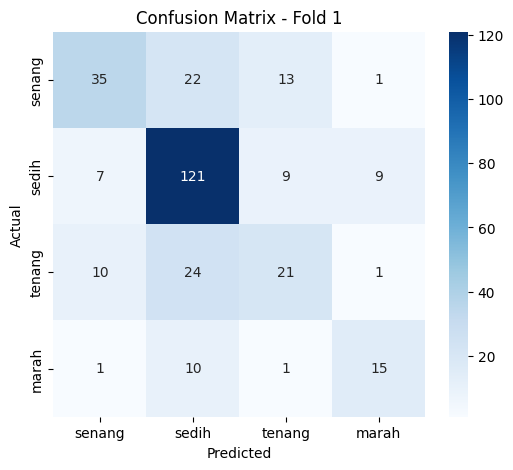

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Pilih fold
fold = 1
fold_df = all_results[all_results['fold'] == fold]

# Buat confusion matrix
cm = confusion_matrix(fold_df['actual_label'], fold_df['predicted_label'])
labels = ['senang','sedih','tenang','marah']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix - Fold {fold}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

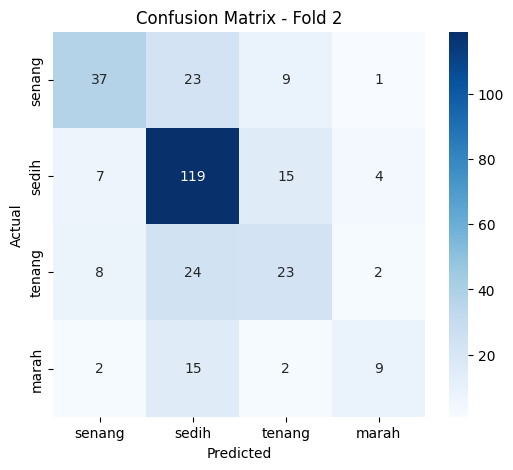

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Pilih fold
fold = 2
fold_df = all_results[all_results['fold'] == fold]

# Buat confusion matrix
cm = confusion_matrix(fold_df['actual_label'], fold_df['predicted_label'])
labels = ['senang','sedih','tenang','marah']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix - Fold {fold}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

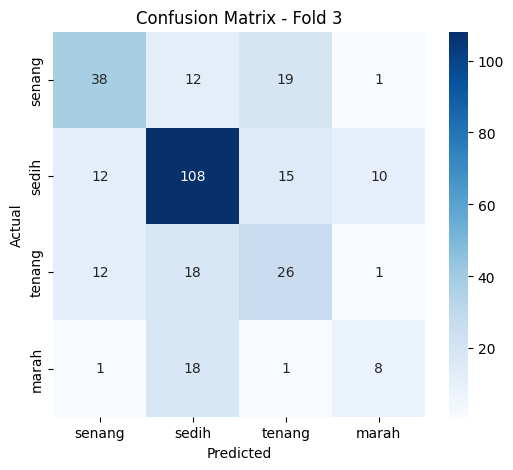

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Pilih fold
fold = 3
fold_df = all_results[all_results['fold'] == fold]

# Buat confusion matrix
cm = confusion_matrix(fold_df['actual_label'], fold_df['predicted_label'])
labels = ['senang','sedih','tenang','marah']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix - Fold {fold}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

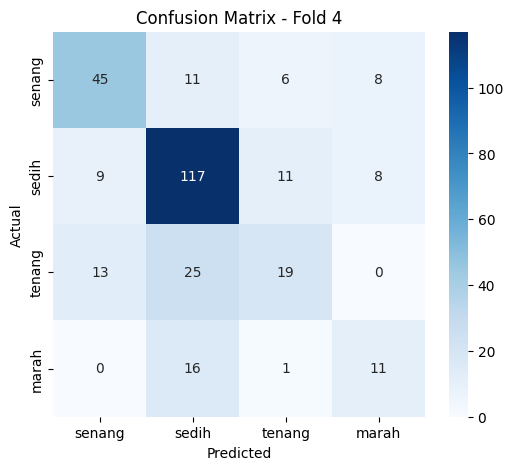

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Pilih fold
fold = 4
fold_df = all_results[all_results['fold'] == fold]

# Buat confusion matrix
cm = confusion_matrix(fold_df['actual_label'], fold_df['predicted_label'])
labels = ['senang','sedih','tenang','marah']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix - Fold {fold}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

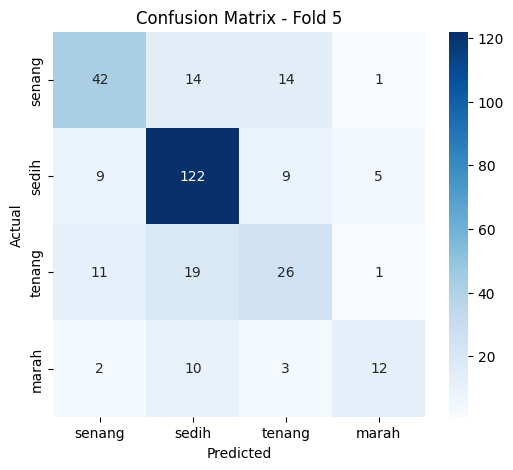

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Pilih fold
fold = 5
fold_df = all_results[all_results['fold'] == fold]

# Buat confusion matrix
cm = confusion_matrix(fold_df['actual_label'], fold_df['predicted_label'])
labels = ['senang','sedih','tenang','marah']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix - Fold {fold}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

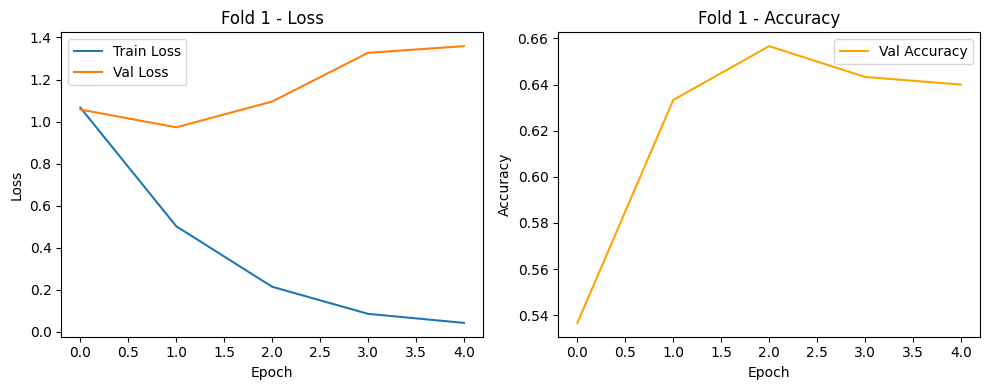

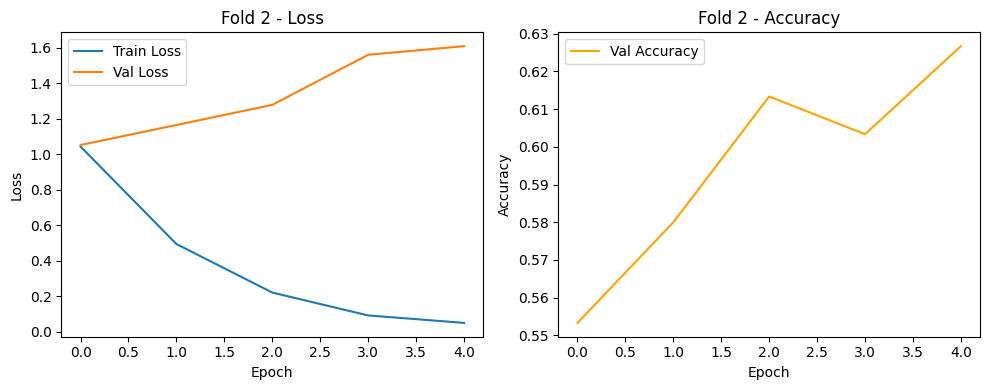

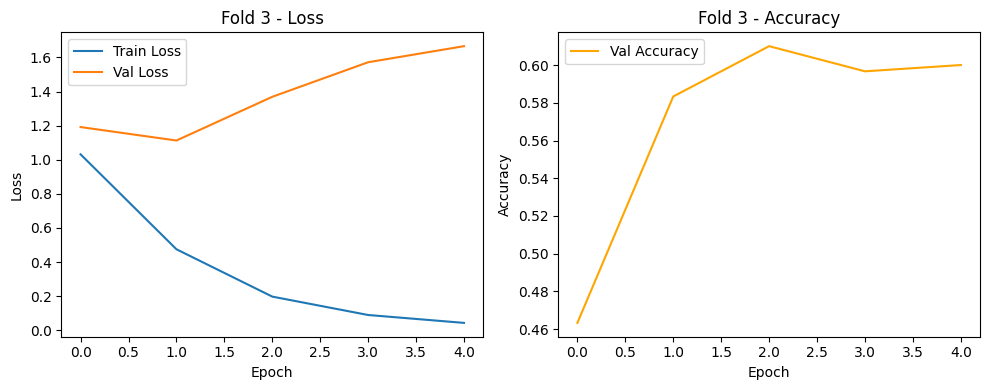

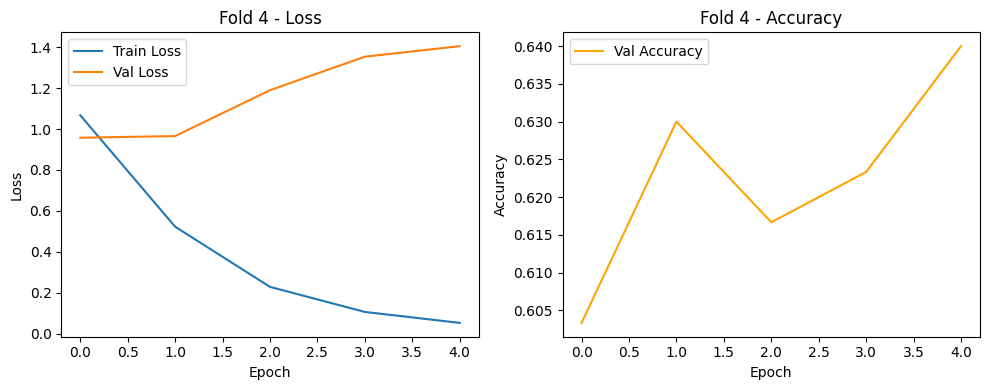

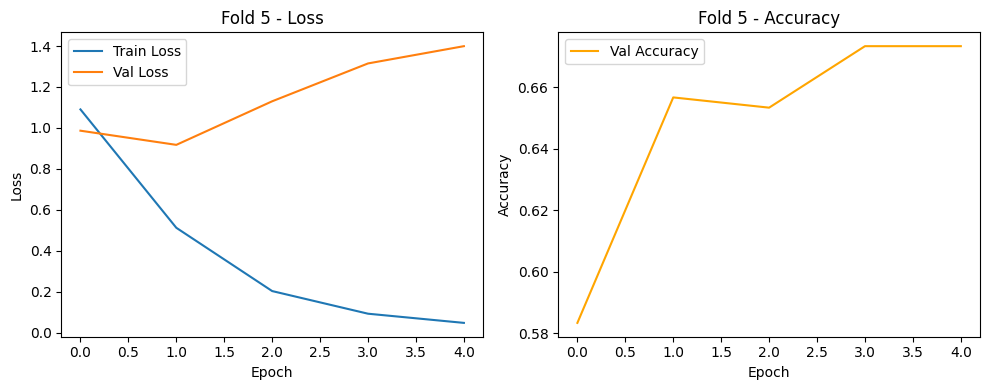

In [ ]:
import numpy as np

# Visualisasi loss dan accuracy per fold
for fold in range(k):
    plt.figure(figsize=(10,4))

    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(all_train_loss[fold], label="Train Loss")
    plt.plot(all_val_loss[fold], label="Val Loss")
    plt.title(f"Fold {fold+1} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(all_val_acc[fold], label="Val Accuracy", color='orange')
    plt.title(f"Fold {fold+1} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd

# List semua file hasil prediksi per fold
k = 5
all_dfs = []

for fold in range(k):
    path = f'/content/drive/MyDrive/TA/FIX/FIX2/k-fold/k-fold2/hasil do2/prediksi_vs_aktual_fold_{fold}.csv'
    df = pd.read_csv(path)
    df['fold'] = fold+1  # tambahkan info fold
    all_dfs.append(df)

# Gabungkan
all_results = pd.concat(all_dfs, ignore_index=True)

# Simpan hasil gabungan
all_results.to_csv('/content/drive/MyDrive/TA/FIX/FIX2/k-fold/k-fold2/hasil do2/all_results.csv', index=False)

print("Gabungan selesai disimpan.")

Gabungan selesai disimpan.


=== Classification Report ===
              precision    recall  f1-score   support

      senang       0.65      0.56      0.60       352
       sedih       0.69      0.81      0.75       726
      tenang       0.47      0.40      0.44       284
       marah       0.51      0.40      0.45       138

    accuracy                           0.64      1500
   macro avg       0.58      0.54      0.56      1500
weighted avg       0.63      0.64      0.63      1500



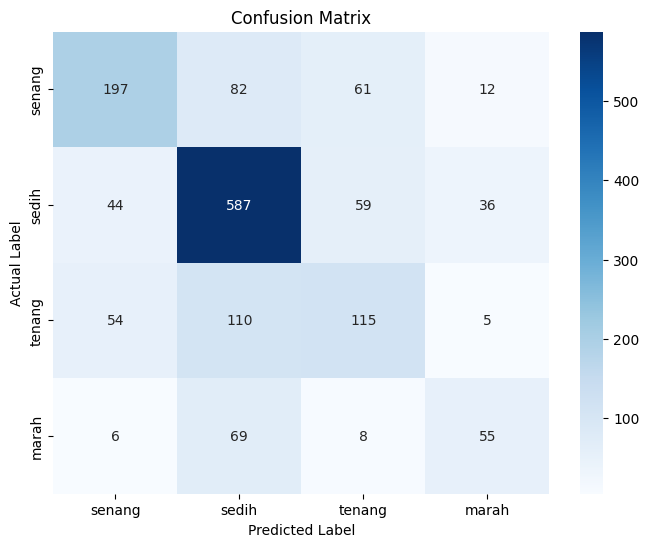

Total salah prediksi: 546 dari 1500 data (36.40%)

                                        cleaned_lirik actual_label_text  \
1   saya tidak tahu harus gimana lagi untuk mencob...             sedih   
3   mata pernah melihat telinga pernah mendengar b...            tenang   
6   memenangkan hatiku bukanlah satu hal yang muda...            senang   
14  ada ruang hatiku yang kautemukan sempat saya l...            senang   
18  indah tentangmu indah akan tersisa di harapan ...            tenang   
20  bu bu eh ada nak dhyo masuk nak eh inenya ada ...             marah   
21  selama ini ribuan hari kudekat denganmu lewati...            tenang   
22  kini bayangmu di sini menemani sepinya hariku ...            senang   
23  aku ingin kau tahu aku ingin kau selalu dekat ...            tenang   
27  semua yang aku mau hanya sedikit waktumu untuk...             sedih   
31  adu du duh berhenti jantungku saat saya baca n...            senang   
35  bukan karna rupa kanda saya cintai bukanlah m

<ipython-input-16-343735743>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=error_per_class.index, y=error_per_class.values, palette='Reds')


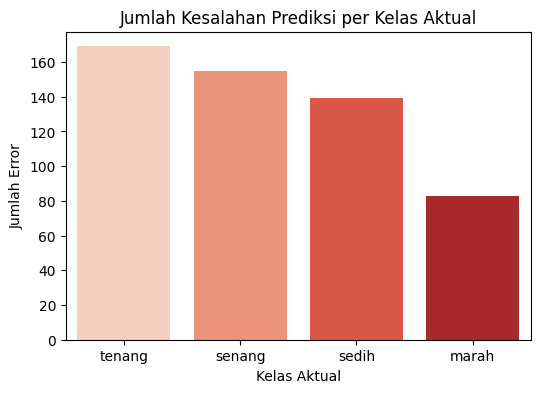

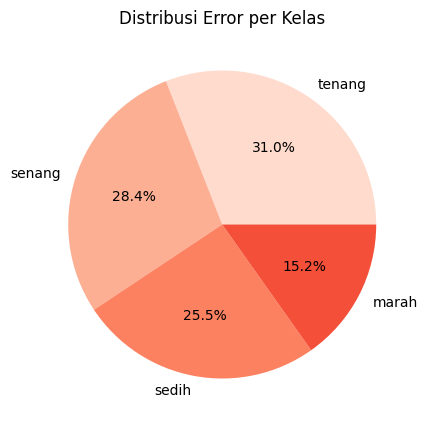

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Load hasil prediksi
all_results = pd.read_csv('/content/drive/MyDrive/TA/FIX/FIX2/k-fold/k-fold2/hasil do2/all_results.csv')

# Mapping label angka ke teks
label_map = {0: 'senang', 1: 'sedih', 2: 'tenang', 3: 'marah'}
all_results['actual_label_text'] = all_results['actual_label'].map(label_map)
all_results['predicted_label_text'] = all_results['predicted_label'].map(label_map)

# 1️⃣ Classification Report (rata-rata per kelas)
y_true = all_results['actual_label']
y_pred = all_results['predicted_label']
report = classification_report(y_true, y_pred, target_names=['senang','sedih','tenang','marah'])
print("=== Classification Report ===")
print(report)

# 2️⃣ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# 3️⃣ Error samples (yang diprediksi salah)
errors = all_results[all_results['actual_label'] != all_results['predicted_label']]
print(f"Total salah prediksi: {len(errors)} dari {len(all_results)} data ({(len(errors)/len(all_results))*100:.2f}%)\n")
print(errors[['cleaned_lirik', 'actual_label_text', 'predicted_label_text']].head(20))

# 4️⃣ Error rate per class
error_per_class = errors['actual_label_text'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=error_per_class.index, y=error_per_class.values, palette='Reds')
plt.title('Jumlah Kesalahan Prediksi per Kelas Aktual')
plt.ylabel('Jumlah Error')
plt.xlabel('Kelas Aktual')
plt.show()

# 5️⃣ Pie chart keseluruhan kesalahan
plt.figure(figsize=(5,5))
plt.pie(error_per_class.values, labels=error_per_class.index, autopct='%1.1f%%', colors=sns.color_palette('Reds'))
plt.title('Distribusi Error per Kelas')
plt.show()

# 6️⃣ Simpan error samples ke CSV
errors.to_csv('/content/drive/MyDrive/TA/FIX/FIX2/k-fold/k-fold2/hasil do2/error_samples.csv', index=False)